# Intepretable ML

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Set2')
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cup98_modeling_data.csv')
r,c = df.shape
print(" Dataset has {} rows and {} columns".format(r,c)) 
df.head()

 Dataset has 95352 rows and 424 columns


AGE   NUMCHLD  INCOME   WEALTH1  HIT  MBCRAFT  MBGARDEN  MBBOOKS  \
0  60.000000  1.527576     4.0  5.345675    0      0.0       0.0      0.0   
1  78.000000  1.527576     2.0  5.345675    0      0.0       0.0      0.0   
2  76.000000  1.527576     2.0  2.000000    2      0.0       0.0      0.0   
3  61.611254  1.527576     4.0  5.345675    0      0.0       0.0      0.0   
4  61.611254  1.527576     4.0  5.345675    0      0.0       0.0      0.0   

   MBCOLECT  MAGFAML  ...  pvstate  inhouse  p3donor  sweeps  homeowner  \
0       0.0      0.0  ...        0        0        0       0          0   
1       0.0      0.0  ...        0        1        0       0          0   
2       0.0      0.0  ...        0        0        0       0          1   
3       0.0      0.0  ...        0        0        0       0          0   
4       0.0      0.0  ...        0        0        0       0          0   

   cluster1_low_01  cluster1_low_02  cluster1_low_03  cluster1_low_04  \
0                0                0                1                0   
1                0                0                1                0   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                1                0   

   cluster1_low_05  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 424 columns]

In [3]:
df_feat=pd.read_csv('selected_features1.csv')
list=df_feat[df_feat.Total >= 5]['Feature'].tolist()  

X = df[list]
y = df['TARGET_B'].rename('target')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

## scaling our data

from sklearn.preprocessing import StandardScaler

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

X_train_std.shape

(85816, 12)

In [4]:
from sklearn.ensemble import RandomForestClassifier
rf_random = RandomForestClassifier(n_estimators = 60,
                           bootstrap = True,
                           min_samples_split=8,
                           min_samples_leaf=5,
                           max_features='auto', 
                                   max_depth=5,
                           random_state = 42)
rf_random.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=60, random_state=42)

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

rf_probs1 = rf_random.predict_proba(X_test_std)
rf_probs1 = rf_probs1[:, 1]
auc_test = roc_auc_score(y_test, rf_probs1)
print('Test accuracy: %.3f' % auc_test)
print('')

Test accuracy: 0.622



In [6]:
from sklearn.linear_model import LogisticRegression
logmodel1 = LogisticRegression(C= 0.01, penalty="l1", solver='liblinear')
logmodel1.fit(X_train_std, y_train)

lr_probs1 = logmodel1.predict_proba(X_test_std)
probs1 = lr_probs1[:, 1]
auc_test = roc_auc_score(y_test, probs1)
    
print('Test accuracy: %.3f' % auc_test)
print('')

Test accuracy: 0.621



# Partial Dependence Plots

In [7]:
from sklearn.inspection import (partial_dependence,  PartialDependenceDisplay)

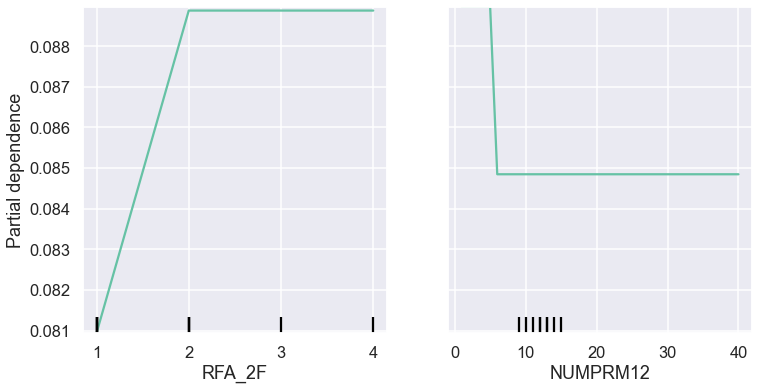

In [8]:
##Random Forest
fig, ax = plt.subplots(figsize=(12, 6))
rf_display  = PartialDependenceDisplay.from_estimator(rf_random, X_train, ['RFA_2F', "NUMPRM12"], ax=ax )



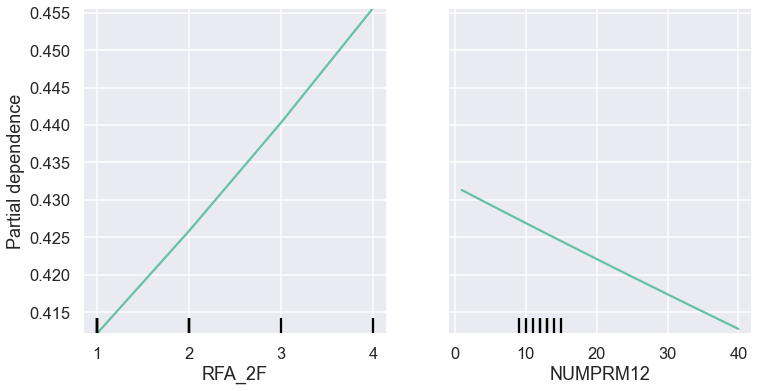

In [9]:
#Logistic Regression
fig, ax = plt.subplots(figsize=(12, 6))
lg_display2  = PartialDependenceDisplay.from_estimator(logmodel1, X_train, ['RFA_2F', "NUMPRM12"], ax=ax)

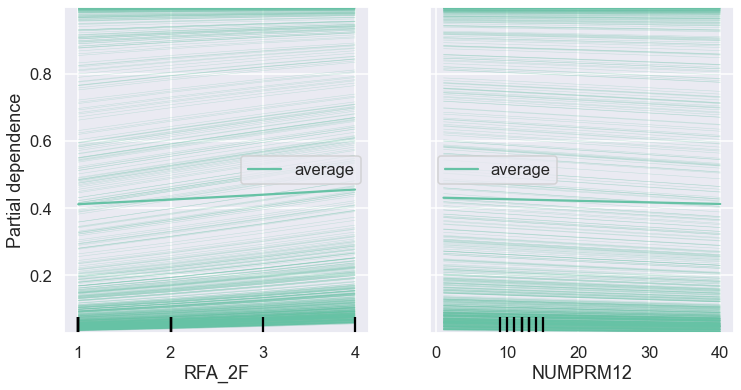

In [10]:
##adding ICE plots
fig, ax = plt.subplots(figsize=(12, 6))
lg_display  = PartialDependenceDisplay.from_estimator(logmodel1, X_train, ['RFA_2F', "NUMPRM12"], ax=ax,kind='both', subsample=800)

Text(0.5, 1.0, 'Logistic Regression')

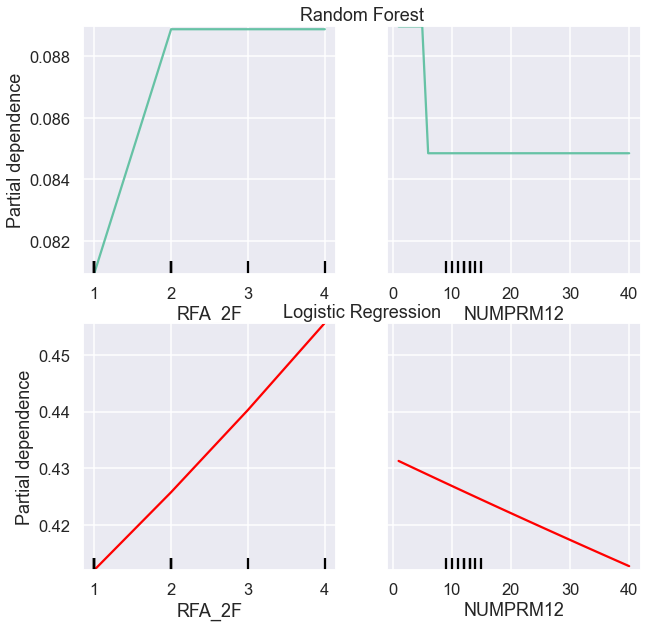

In [11]:
###comparing 2 models

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
rf_display.plot(ax=ax1)
ax1.set_title("Random Forest")
lg_display2.plot(ax=ax2, line_kw={"color": "red"})
ax2.set_title("Logistic Regression")

# Eli5

In [12]:
#Importing the module
from eli5 import show_weights


In [15]:
#Feature Importance

show_weights(rf_random, feature_names = list(X_test.columns))

In [16]:
show_weights(logmodel1, feature_names = list(X_test.columns))

In [17]:
#Taking an example of test data...individual contribution
from eli5 import show_prediction
show_prediction(rf_random, X_test.iloc[88], show_feature_values=True)

In [18]:
#Taking an example of test data...individual contribution
from eli5 import show_prediction
show_prediction(logmodel1, X_test.iloc[88], show_feature_values=True)

# SHAP

In [19]:
import shap

In [20]:
##Explain the random forest model
explainer1 = shap.LinearExplainer(logmodel1, X_test)
shap_values = explainer1.shap_values(X_test)

In [21]:
pd.DataFrame(shap_values, columns=X_test.columns).head(5)

log_days_since_last    RFA_2F  MAXRAMNT  CARDPROM  log_MAXRAMNT  \
0             0.008827  0.179394      -0.0 -0.019501      0.023690   
1            -0.001247  0.348633      -0.0  0.012049      0.023690   
2            -0.006994 -0.159085      -0.0  0.016556      0.016375   
3            -0.021025 -0.159085      -0.0 -0.011989      0.007422   
4             0.066564  0.179394      -0.0  0.001532     -0.004121   

   log_AVGGIFT  RFA_2A_G  PEPSTRFL_ind  NUMPRM12  NGIFTALL      HVP3      HVP1  
0         -0.0  0.008608     -0.062292  0.012254 -0.070547 -2.434716 -0.347974  
1         -0.0  0.008608      0.059849 -0.005086  0.233818 -2.195941 -0.347974  
2         -0.0  0.008608      0.059849  0.006474  0.049025  1.624471 -0.007565  
3          0.0  0.008608     -0.062292  0.018034 -0.070547 -2.116349 -0.347974  
4         -0.0  0.008608     -0.062292 -0.016647  0.005544 -2.036757 -0.347974

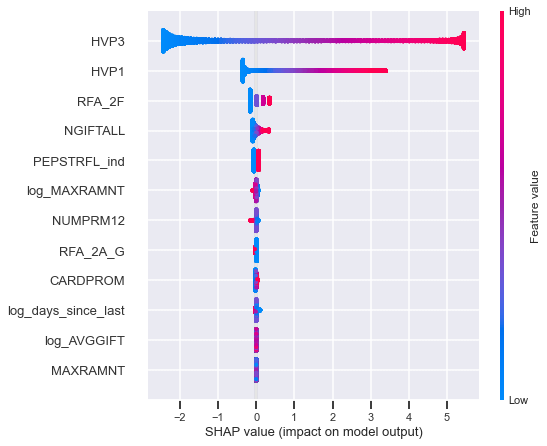

In [22]:
shap.summary_plot(shap_values,X_test, feature_names = list(X_test.columns))

In [23]:
# row 6
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values[7, :], X_test.iloc[7, :])

In [24]:
# row 87
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values[88, :], X_test.iloc[88, :])

In [25]:
##Explain the random forest model
# Create Tree Explainer object that can calculate shap values
explainer2 = shap.TreeExplainer(rf_random)
shap_values2 = explainer2.shap_values(X_test)

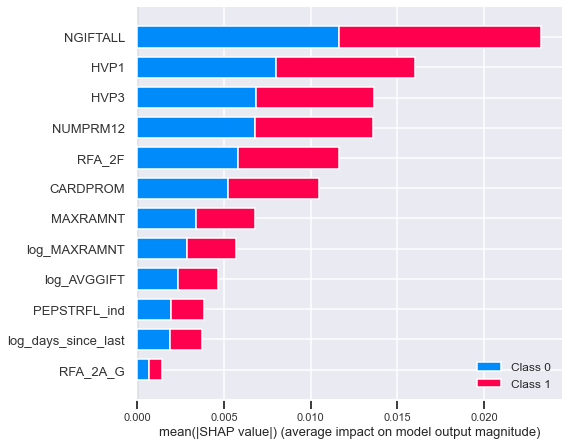

In [26]:
shap.summary_plot(shap_values2,X_test, feature_names = list(X_test.columns))

In [27]:
# Calculate Shap values
choosen_instance = X_test.iloc[7]
shap_values = explainer2.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer2.expected_value[1], shap_values[1], choosen_instance)

# LIME

In [32]:
import lime
from lime import lime_tabular

In [33]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

In [34]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[88], 
    predict_fn=rf_random.predict_proba
)

exp.show_in_notebook(show_table=True)

In [35]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[88], 
    predict_fn=logmodel1.predict_proba
)

exp.show_in_notebook(show_table=True)